## Food_Vision_Project:
** What will be Covering in this**:
1) Using TensorFlow Datasets to download and explore data
2) Creating preprocessing function for our data
   Batching & preparing datasets for modelling (making our datasets run fast)
3) Creating modelling callbacks
4) Setting up mixed precision training
5) Building a feature extraction model
6) Fine-tuning the feature extraction model
7) Viewing training results on TensorBoard

In [ ]:
# Lets check what kind of GPU we are using
!nvidia-smi

Sun Oct 19 19:23:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Use TensorFlow Datasets to Download Data

**why to use Tensorflow Datasets:**
1) Load data already in Tensors
2) Practice on well established datasets
3) Experiment with differet data loading techniques
4) Experiment with new TensorFlow features quickly (such as mixed precision training)

In [ ]:

# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [ ]:
# Load in the data:
(train_data, test_data),ds_info =tfds.load(name="food101",
                                           split=["train","validation"],
                                           shuffle_files=True,
                                           as_supervised=True, # data get return in tuple format (train,label)
                                           with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.0AH0T2_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.0AH0T2_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## NOw let just Exploer the Data which we have downloaded from Tensorflow-Datasets:

1) class_names
2) shape
3) datatype
4) labels

In [ ]:
# Features of Food101:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# lets see the class_names
class_names=ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [ ]:

# lets see how does our train data looklike
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# lets take one sample from train data
one_sample=train_data.take(1)
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        


In [ ]:
# let see what image look like in tensor form
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

## Lets Visualize the Image from the Dataset

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

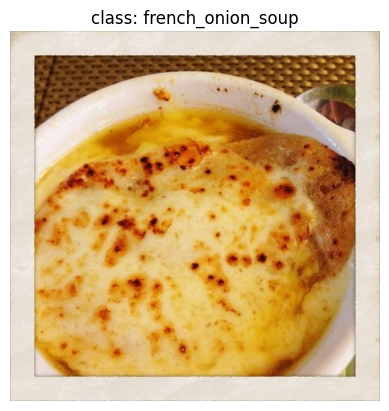

In [ ]:
# lets plot the image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

plt.imshow(image)
plt.title(f"class: {class_names[label]}")
plt.axis(False)

## Lets Now move toward the Preprocessing :

We need to convert all of our data into same:
1) shape
2) datatype
3) converting them into batches
4) sometime need to normalized

In [ ]:
# Create a preprocessing function for our data
def process_img(image,label,img_shape=224):

  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label


In [ ]:
def augment(image, label,img_shape=224):
    # Apply random transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)  # if you want vertical flips
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # maybe random crop / zoom
    image = tf.image.resize_with_crop_or_pad(image, img_shape+10, img_shape+10)  # pad
    image = tf.image.random_crop(image, size=[img_shape, img_shape, 3])
    # ensure still in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [ ]:
# Lets check the preprocessed_img
preprocessed_img=process_img(image,label)[0]
preprocessed_img=augment(preprocessed_img,label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

## Batch and Prepare our Data

In [ ]:
# Map processing function to Training
train_data=train_data.map(map_func=process_img,num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn them into batches
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to training data
test_data=test_data.map(process_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating Modelling Callbacks:

1) TensorBoard Callbacks to long training result
2) Modelcheckpoint callback to save our models progress after feature extraction

In [ ]:
# Creating Tensorboard Callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  return tensorboard_callback

# Create a ModelCheckpoint callback to save model's progress during training
checkpoint_path="model_checkpoints/cp.weights.h5"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor="val_acc",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0)

## Creating setup for Mixed Precision Training

** What is that :**

It is a combiantion of float32 and float16 datatype which helps to speed up the model training approximately 3X times using GPU

In [ ]:
# lets get the mixed precision training live
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

##Now lets move to Build Feature Extraction Model


In [ ]:
batch_size=32

In [ ]:
from tensorflow.keras import layers

# create a base model
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# CReate a Functional Model
inputs=tf.keras.layers.Input(shape=input_shape)
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation("softmax",dtype=tf.float32)(x)


model=tf.keras.Model(inputs,outputs)

# Compile a model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model
history=model.fit(train_data,
                  epochs=2,
                  steps_per_epoch=2368,
                  validation_data=test_data,
                  validation_steps=int(np.ceil(len(test_data) / batch_size)),
                  callbacks=[create_tensorboard_callback("train_log","EfficientNetB_food"),
                             checkpoint_callback])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4762 - loss: 2.2911

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_acc available.
  if self._should_save_model(epoch, batch, logs, filepath):


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 254s 83ms/step - accuracy: 0.4763 - loss: 2.2908 - val_accuracy: 0.6737 - val_loss: 1.1646
Epoch 2/2
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 153s 64ms/step - accuracy: 0.6689 - loss: 1.2881 - val_accuracy: 0.6925 - val_loss: 1.1009


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.7196 - loss: 1.0366


[1.0338022708892822, 0.722891092300415]

##Load and evaluate checkpoint weights
We can load in and evaluate our model's checkpoints by:

Recreating a new instance of our model called created_model by turning our original model creation code into a function called create_model().

Compiling our created_model with the same loss, optimizer and metrics as the original model (every time you create a new model, you must compile it).

Calling the load_weights() method on our created_model and passing it the path to where our checkpointed weights are stored.

Calling evaluate() on created_model with loaded weights and saving the results.

Comparing the created_model results to our previous model results (these should be the exact same, if not very close).

In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 75s 68ms/step - accuracy: 0.7191 - loss: 1.0375


In [ ]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_2 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

##Save the whole model to file:

We can also save the whole model using the save() method.

In [ ]:
# ## Saving model to Google Drive (optional)
import os

# Create save path to drive
save_dir = "/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/.h5"
#os.makedirs(save_dir) # Make directory if it doesn't exist

#Save model
model.save(save_dir)

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

##Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember the goal of beating the DeepFood paper !!!

In [ ]:
# Download the saved model from Google Storage
!wget /content/07_efficientnetb0_feature_extract_model_mixed_precision.zip.2

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir model_gs # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d model_gs

In [ ]:
!mkdir GS_MODEL

In [ ]:
model.save("/content/GS_MODEL/.h5")

In [ ]:
import tensorflow as tf

loaded_gs =tf.keras.models.load_model(
    "/content/GS_MODEL/.h5"
)

In [ ]:
# Get a summary of our downloaded model
# Print the layers of the model
for layer in loaded_gs.layers:
    print(layer.name, layer.__class__.__name__)

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs.evaluate(test_data)
results_loaded_gs_model

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

##A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

** It could be a couple of hours or in the case of the DeepFood paper (the baseline we're trying to beat)

** Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

## The EarlyStopping callback:
 can help us to solve our problem

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_gs.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

## All the process is done :     
Our model is compiled now lets move to fit the model using all the callbacks and for 100 epochs

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

In [ ]:
 loaded_gs.evaluate(test_data)

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs.save("Our_final_model.keras")

In [ ]:
# # Upload experiment results to TensorBoard (uncomment to run)
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot